https://chatgpt.com/c/681cd632-c3e8-8012-9f27-14596a757710

In [ ]:
# | default_exp analyses.rpl

# Recall Probability by Spacing
> "The beneficial mnemonic effects of spaced over massed learning is one of the most widely documented and well studied memory phenomena. Although it is seen in a wide range of tasks, the spacing effect is particularly strong in free recall, where the probability of recalling a repeated word often increases monotonically to spacings of 20 or more items (Cepeda, Pashler, Vul, Wixted, & Rohrer, 2006; Delaney, Verkoeijen, & Spirgel, 2010; Donovan & Radosevich, 1999; Madigan, 1969; Melton, 1970)." - Lohnas & Kahana, 2014

In [ ]:
# | export

import jax.numpy as jnp
from jax import vmap, jit

from typing import Optional, Sequence
from jaxcmr.typing import Array, Float, Integer, Bool, RecallDataset, Int_
from jaxcmr.repetition import item_to_study_positions
from jaxcmr.plotting import init_plot, plot_data, set_plot_labels
from jaxcmr.helpers import apply_by_subject, find_max_list_length

from matplotlib.axes import Axes
from matplotlib import rcParams  # type: ignore


In [ ]:
# | export
def infer_max_lag(
    presentations: Integer[Array, " trials study_events"],
    list_length: int,
) -> int:
    """
    Return the largest first-to-second-presentation distance observed anywhere
    in `presentations`.
    """
    all_items = jnp.arange(1, list_length + 1)
    positions = vmap(
        vmap(item_to_study_positions, in_axes=(0, None, None)), in_axes=(None, 0, None)
    )(all_items, presentations, 2)
    return jnp.max(jnp.maximum(positions[..., 1] - positions[..., 0], 0)).item() - 1


def item_lag_counts(
    target_item: Int_,
    recalls: Integer[Array, " recall_events"],
    presentation: Integer[Array, " study_events"],
    max_lag: int,
    n_bins: int,
) -> tuple[Bool[Array, " lag_bins"], Bool[Array, " lag_bins"]]:
    """
    Return one-hot vectors (presented, recalled) for `target_item`'s lag bin.

    Args:
        target_item: item ID to tabulate.
        recalls: first study positions of recalled items (1-indexed; 0 = no recall).
        presentation: item IDs presented at each study position (1-indexed).
        max_lag: largest explicit lag bucket.
            - bin 0  → single presentation (lag 0)
            - bin k  → k intervening items, 1 ≤ k ≤ max_lag
            - bin max_lag + 1 → lag > max_lag (overflow)
        n_bins: total number of bins (`max_lag + 2`).

    Each vector has at most one `True`.  Summing over items/trials yields counts.
    """
    # 1‒index positions of first / second presentation (0 if absent)
    first_pos, second_pos = item_to_study_positions(target_item, presentation, size=2)

    # lag = 0 when only one presentation or item absent
    lag = jnp.maximum(second_pos - first_pos, 0)
    bin_index = jnp.clip(lag, 0, max_lag + 1)

    presented = (jnp.arange(n_bins) == bin_index) & (first_pos > 0)
    recalled = presented & jnp.any(recalls == first_pos)  # compares positions, not IDs

    return presented, recalled


def _trial_lag_counts(
    recalls: Integer[Array, " recall_events"],
    presentations: Integer[Array, " study_events"],
    all_items: Integer[Array, " items"],
    max_lag: int,
    n_bins: int,
) -> tuple[Float[Array, " lag_bins"], Float[Array, " lag_bins"]]:
    """Aggregate presented / recalled one-hot vectors for one trial."""
    presented, recalled = vmap(
        item_lag_counts,
        in_axes=(0, None, None, None, None),  # map over items
    )(all_items, recalls, presentations, max_lag, n_bins)

    return presented.sum(0), recalled.sum(0)


def recall_probability_by_lag(
    recalls: Integer[Array, " trials recall_events"],
    presentations: Integer[Array, " trials study_events"],
    list_length: int,
    max_lag: int = 8,
) -> Float[Array, " lag_bins"]:
    """
    Return recall probability for lag 0, 1, ..., `max_lag`, plus once-presenteds items.

    Args:
        recalls: first study positions of recalled items (1-indexed; 0 = no recall).
        presentations: item IDs presented at each study position (1-indexed).
        list_length: number of items in the study list.
        max_lag: largest explicit lag bucket.
            - bin 0  → single presentation (lag 0)
            - bin k  → k intervening items, 1 ≤ k ≤ max_lag
            - bin max_lag + 1 → lag > max_lag (overflow)
    """
    n_bins = max_lag + 2
    all_items = jnp.arange(1, list_length + 1)  # 1...list_length

    # Map over trials
    presented_t, recalled_t = vmap(
        _trial_lag_counts,
        in_axes=(0, 0, None, None, None),  # map over trials
    )(recalls, presentations, all_items, max_lag, n_bins)

    presented_tot = presented_t.sum(0)
    recalled_tot = recalled_t.sum(0)

    # Guard against divide-by-zero
    return jnp.where(presented_tot > 0, recalled_tot / presented_tot, 0.0)


def binned_recall_probability_by_lag(
    recalls: Integer[Array, " trials recall_events"],
    presentations: Integer[Array, " trials study_events"],
    list_length: int,
    max_lag: int = 8,
) -> Float[Array, " lag_bins"]:
    """
    Return binned recall probability for lag 0, 1, ..., `max_lag`, plus once-presenteds items.

    Args:
        recalls: first study positions of recalled items (1-indexed; 0 = no recall).
        presentations: item IDs presented at each study position (1-indexed).
        list_length: number of items in the study list.
        max_lag: largest explicit lag bucket.
            - bin 0  → single presentation (lag 0)
            - bin k  → k intervening items, 1 ≤ k ≤ max_lag
            - bin max_lag + 1 → lag > max_lag (overflow)
    """
    result = recall_probability_by_lag(recalls, presentations, list_length, max_lag)
    return (
        jnp.zeros(5)
        .at[0]
        .set(result[0])
        .at[1]
        .set(result[1])
        .at[2]
        .set((result[2] + result[3]) / 2)
        .at[3]
        .set((result[4] + result[5] + result[6]) / 3)
        .at[4]
        .set((result[7] + result[8] + result[9]) / 3)
    )

In [ ]:
# | exports


def plot_full_rpl(
    datasets: Sequence[RecallDataset] | RecallDataset,
    trial_masks: Sequence[Bool[Array, " trial_count"]] | Bool[Array, " trial_count"],
    distances: Optional[Float[Array, "word_count word_count"]] = None,
    color_cycle: Optional[list[str]] = None,
    labels: Optional[Sequence[str]] = None,
    contrast_name: Optional[str] = None,
    axis: Optional[Axes] = None,
    size: int = 3,
) -> Axes:
    """Returns Axes object with plotted serial position curve for datasets and trial masks.

    Args:
        datasets: Datasets containing trial data to be plotted.
        trial_masks: Masks to filter trials in datasets.
        color_cycle: List of colors for plotting each dataset.
        distances: Unused, included for compatibility with other plotting functions.
        labels: Names for each dataset for legend, optional.
        contrast_name: Name of contrast for legend labeling, optional.
        axis: Existing matplotlib Axes to plot on, optional.
        size: Maximum number of study positions an item can be presented at.
    """
    axis = init_plot(axis)

    if color_cycle is None:
        color_cycle = [each["color"] for each in rcParams["axes.prop_cycle"]]

    if labels is None:
        labels = [""] * len(datasets)

    if isinstance(datasets, dict):
        datasets = [datasets]

    if isinstance(trial_masks, jnp.ndarray):
        trial_masks = [trial_masks]

    max_list_length = find_max_list_length(datasets, trial_masks)
    max_lag = infer_max_lag(datasets[0]["pres_itemnos"], max_list_length)
    for data_index, data in enumerate(datasets):
        subject_values = jnp.vstack(
            apply_by_subject(
                data,
                trial_masks[data_index],
                jit(
                    recall_probability_by_lag,
                    static_argnames=("max_lag", "list_length"),
                ),
                max_lag,
            )
        )

        color = color_cycle.pop(0)
        plot_data(
            axis,
            ["N/A"] + [f"{i}" for i in range(max_lag + 1)],
            subject_values,
            labels[data_index],
            color,
        )

    set_plot_labels(axis, "Lag", "Recall Rate", contrast_name)
    return axis


def plot_rpl(
    datasets: Sequence[RecallDataset] | RecallDataset,
    trial_masks: Sequence[Bool[Array, " trial_count"]] | Bool[Array, " trial_count"],
    distances: Optional[Float[Array, "word_count word_count"]] = None,
    color_cycle: Optional[list[str]] = None,
    labels: Optional[Sequence[str]] = None,
    contrast_name: Optional[str] = None,
    axis: Optional[Axes] = None,
    size: int = 3,
) -> Axes:
    """Returns Axes object with plotted serial position curve for datasets and trial masks.

    Args:
        datasets: Datasets containing trial data to be plotted.
        trial_masks: Masks to filter trials in datasets.
        color_cycle: List of colors for plotting each dataset.
        distances: Unused, included for compatibility with other plotting functions.
        labels: Names for each dataset for legend, optional.
        contrast_name: Name of contrast for legend labeling, optional.
        axis: Existing matplotlib Axes to plot on, optional.
        size: Maximum number of study positions an item can be presented at.
    """
    axis = init_plot(axis)

    if color_cycle is None:
        color_cycle = [each["color"] for each in rcParams["axes.prop_cycle"]]

    if labels is None:
        labels = [""] * len(datasets)

    if isinstance(datasets, dict):
        datasets = [datasets]

    if isinstance(trial_masks, jnp.ndarray):
        trial_masks = [trial_masks]

    max_list_length = find_max_list_length(datasets, trial_masks)
    max_lag = infer_max_lag(datasets[0]["pres_itemnos"], max_list_length)
    for data_index, data in enumerate(datasets):
        subject_values = jnp.vstack(
            apply_by_subject(
                data,
                trial_masks[data_index],
                jit(
                    binned_recall_probability_by_lag,
                    static_argnames=( "list_length", "max_lag"),
                ),
                max_lag,
            )
        )

        color = color_cycle.pop(0)
        plot_data(
            axis,
            ['N/A', '0', '1-2', '3-5', '6-8'],
            subject_values,
            labels[data_index],
            color,
        )

    set_plot_labels(axis, "Lag", "Recall Rate", contrast_name)
    return axis

In [ ]:
from jaxcmr.helpers import generate_trial_mask, load_data, find_project_root
from jaxcmr.repetition import make_control_dataset
import matplotlib.pyplot as plt
import os


[0.3727891  0.43928573 0.47678572 0.5571428  0.57857144]


<Axes: xlabel='Lag', ylabel='Recall Rate'>

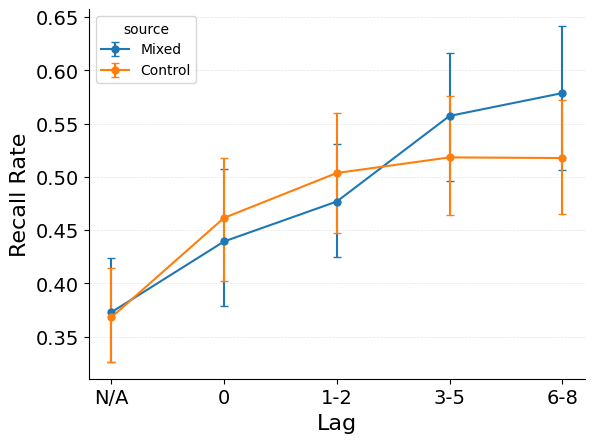

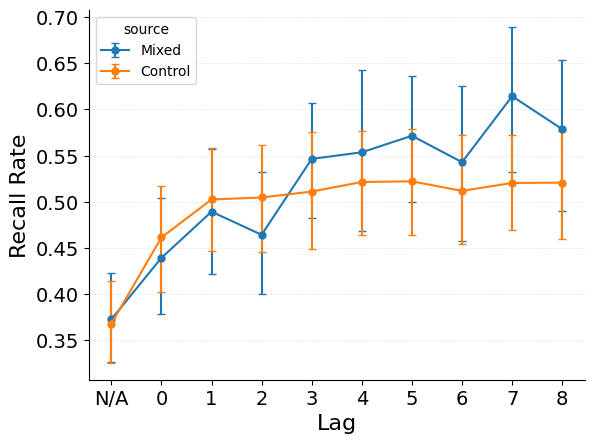

In [ ]:
# parameters
data_name = "LohnasKahana2014"
data_query = "data['list_type'] == 4"
ctrl_query = "data['list_type'] == 1"

data_path = os.path.join(find_project_root(), "data/LohnasKahana2014.h5")

# set up data structures
data = load_data(data_path)
recalls = data["recalls"]
presentations = data["pres_itemnos"]
list_length = data["listLength"][0].item()
trial_mask = generate_trial_mask(data, data_query)

print(binned_recall_probability_by_lag(
    recalls[trial_mask], presentations[trial_mask], list_length, infer_max_lag(presentations[trial_mask], list_length)
))

control_dataset = make_control_dataset(data, data_query, ctrl_query, 10)
plot_rpl([data, control_dataset], [generate_trial_mask(data, data_query), generate_trial_mask(control_dataset, data_query)], labels=["Mixed", "Control"], contrast_name="source")
plot_full_rpl([data, control_dataset], [generate_trial_mask(data, data_query), generate_trial_mask(control_dataset, data_query)], labels=["Mixed", "Control"], contrast_name="source")